# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [6]:
## Checking the GPU configuration

!nvidia-smi

Sun Jul 11 09:03:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
import numpy as np
import os
import imageio
import datetime
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [63]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [71]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 13 #experiment with the batch size

In [72]:
# function to plot the training/validation accuracies/losses.
from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [73]:
y = 120 # width of the image
z = 120 # height of the image

In [105]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    if image.shape[0] != image.shape[1]:
                      image=image[0:120,20:140]                                 
                         
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    image_resized= resized = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size != 0):           
            batch_size = len(t)%batch_size
            print(batch_size)
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                   #crop the images and resize them. Note that the images are of 2 different shape
                    if image.shape[0] != image.shape[1]:
                      image=image[0:120,20:140]                                 
                         
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    image_resized= resized = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [106]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [107]:
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
nb_frames = 30  # length of the video frames
nb_channel = 3

In [108]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from tensorflow.keras import optimizers
from keras.optimizers import Adam

from tensorflow.keras.applications import mobilenet

**Base Model**

In [80]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(30,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 60, 60, 32)   

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [96]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [97]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = 'gdrive/My Drive/Gesture_Recog/'+ model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [98]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [84]:
batch_size = 13
num_epochs = 1
history1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 13
51/51 [==============================] - 61s 1s/step - loss: 1.6242 - categorical_accuracy: 0.3756 - val_loss: 3.4595 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-1.62420-0.37557-3.45950-0.17000.h5


### **Model 1 - Conv3D (Batch Size - 39, No. of Epochs - 30)**

In [85]:
# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

#write your model here
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [86]:
from keras.optimizers import Adam
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_21 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 60, 60, 32)   

In [87]:
batch_size = 39 
num_epochs = 30
history1 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
51/51 [==============================] - 60s 1s/step - loss: 1.4744 - categorical_accuracy: 0.4570 - val_loss: 4.1774 - val_categorical_accuracy: 0.1250

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-1.47444-0.45701-4.17739-0.12500.h5
Epoch 2/30
51/51 [==============================] - 51s 1s/step - loss: 0.9601 - categorical_accuracy: 0.6305 - val_loss: 7.2134 - val_categorical_accuracy: 0.1250

Epoch 00002: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00002-0.96011-0.63047-7.21340-0.12500.h5
Epoch 3/30
51/51 [==============================] - 51s 1s/step - loss: 0.7985 - categorical_accuracy: 0.6863 - val_loss: 4.6522 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00003-0.79854-0.68627-4.65220-0.37500.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

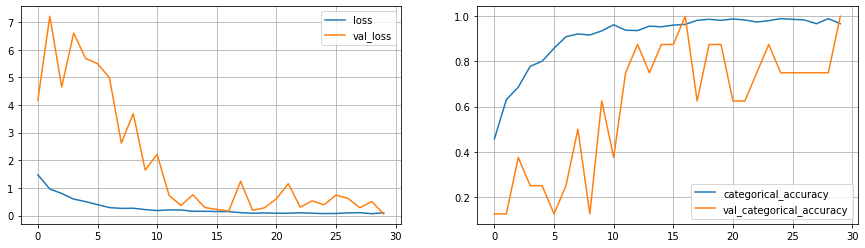

In [89]:
plot(history1)

- Categorical Accuracy = 96.6%
- Validation Accuracy  = 100 %

**Inference - Model seems to be overfitting and there are alot of fluctuations in the validation accuracy. For some sample of the validation data it gives high accuracy but for some very low.**

### **Model 2 - Conv2D (Batch Size - 17, No. of Epochs - 30)**

In [99]:
batch_size = 17
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 17
Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 0.0708 - categorical_accuracy: 0.9894Source path =  Project_data/val ; batch size = 17
15
39/39 [==============================] - 62s 2s/step - loss: 0.0708 - categorical_accuracy: 0.9894 - val_loss: 0.4543 - val_categorical_accuracy: 0.8100

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-0.07081-0.98944-0.45434-0.81000.h5
Epoch 2/30
39/39 [==============================] - 58s 2s/step - loss: 0.0600 - categorical_accuracy: 0.9910 - val_loss: 0.5552 - val_categorical_accuracy: 0.8000

Epoch 00002: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00002-0.06001-0.99095-0.55516-0.80000.h5
Epoch 3/30
39/39 [==============================] - 56s 1s/step - loss: 0.0548 - categorical_accuracy: 0.9910 - val_loss: 0.3829 - val_categorical_accuracy: 0.8333

Epoch 00003: saving 

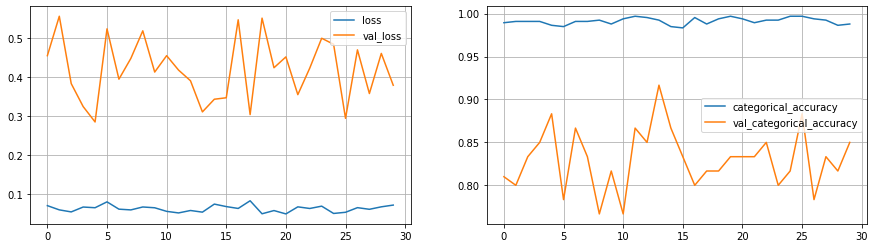

In [100]:
plot(history2)

- Categorical Accuracy = 98%
- Validation Accuracy = 85%

**Inference - Model performs well on the training data but not on the validation data. Hence overfits.**

### **Model 3 - Conv3D Increasing Dropout to reduce Overfitting (Batch Size - 17, No. of Epochs - 25)**

In [109]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(30,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_29 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 15, 60, 60, 32)   

In [110]:
batch_size = 17
num_epochs = 25

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
39/39 [==============================] - 64s 1s/step - loss: 1.9475 - categorical_accuracy: 0.3756 - val_loss: 2.4115 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-1.94749-0.37557-2.41152-0.15000.h5
Epoch 2/25
39/39 [==============================] - 57s 1s/step - loss: 1.5736 - categorical_accuracy: 0.4374 - val_loss: 4.8213 - val_categorical_accuracy: 0.1833

Epoch 00002: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00002-1.57362-0.43741-4.82130-0.18333.h5
Epoch 3/25
39/39 [==============================] - 60s 2s/step - loss: 1.2761 - categorical_accuracy: 0.5309 - val_loss: 6.9476 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00003-1.27612-0.53092-6.94756-0.15000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

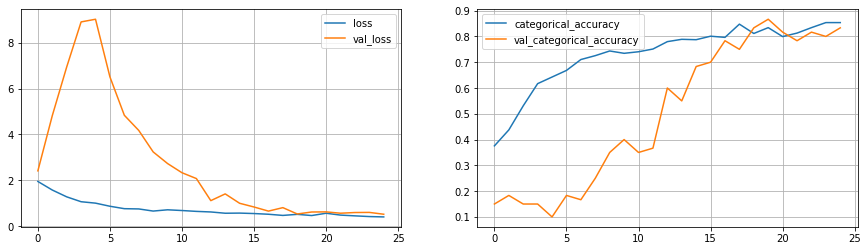

In [111]:
plot(history3)

- Categorical Accuracy = 85.3%
- Validation Accuracy = 83.3%

**Inference - Here we see that the model performs well  both on the training and validation data. Also, fluctuations in the validation accuracy have reduced.**

### **Model 4 (CNN GRU)**

In [112]:
from tensorflow.keras.layers import LSTM,GRU
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.3))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
        
model.add(Dense(5, activation='softmax'))

In [113]:
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 30, 30, 64)  

In [114]:
batch_size=39
num_epochs=30

history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
39/39 [==============================] - 59s 1s/step - loss: 1.5301 - categorical_accuracy: 0.3605 - val_loss: 2.3427 - val_categorical_accuracy: 0.1667

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-1.53008-0.36048-2.34273-0.16667.h5
Epoch 2/30
39/39 [==============================] - 55s 1s/step - loss: 1.2122 - categorical_accuracy: 0.4872 - val_loss: 2.6830 - val_categorical_accuracy: 0.1833

Epoch 00002: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00002-1.21223-0.48718-2.68301-0.18333.h5
Epoch 3/30
39/39 [==============================] - 56s 1s/step - loss: 1.0891 - categorical_accuracy: 0.5354 - val_loss: 2.8182 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00003-1.08908-0.53544-2.81822-0.20000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

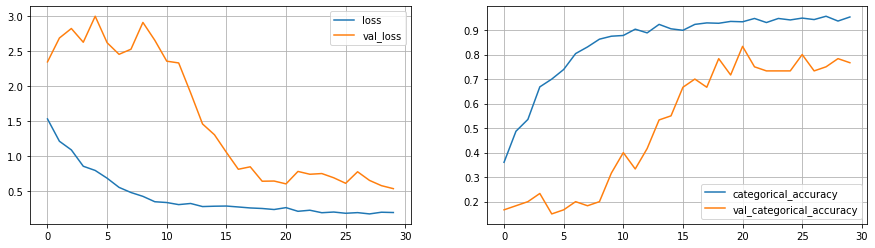

In [115]:
plot(history4)

- Categorical Accuracy = 95%
- Validation Accuracy = 76%

**This model does not give a good accuracy on the validation data**

### **Model 5 (Transfer Learning using MobileNet and training all weights)**

In [116]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, Dense
from tensorflow.keras.applications import mobilenet

In [117]:

input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [118]:
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)             

In [119]:
batch_size=39
num_epochs=25

history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
39/39 [==============================] - 72s 2s/step - loss: 1.1619 - categorical_accuracy: 0.5294 - val_loss: 0.7626 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00001-1.16187-0.52941-0.76259-0.70000.h5
Epoch 2/25
39/39 [==============================] - 62s 2s/step - loss: 0.5444 - categorical_accuracy: 0.7934 - val_loss: 0.7071 - val_categorical_accuracy: 0.7333

Epoch 00002: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00002-0.54444-0.79336-0.70710-0.73333.h5
Epoch 3/25
39/39 [==============================] - 63s 2s/step - loss: 0.4064 - categorical_accuracy: 0.8582 - val_loss: 0.5921 - val_categorical_accuracy: 0.7667

Epoch 00003: saving model to gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00003-0.40645-0.85822-0.59207-0.76667.h5
Epoch 4/25
39/39 [==============================] - 63s 2s/step - loss: 0.39

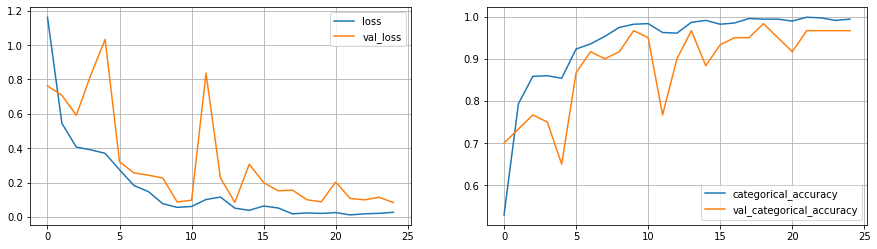

In [120]:
plot(history5)

**This model almost reached 100% accuracy, hence seems to be Overfitting to the train data**

**After doing all the experiments, we finalized Model 3 - Conv3D, which performed well.**

**Reason :** Good Training and testing accuracy

### Load Model and predict on the validation set

In [121]:
import time
from keras.models import load_model
model = load_model('gdrive/My Drive/Gesture_Recog/model_init_2021-07-1110_16_18.363209/model-00025-0.39907-0.85370-0.51638-0.83333.h5')

In [122]:
Final_val=generator(val_path, val_doc, batch_size)
batch_data, batch_labels=next(Final_val)


Source path =  Project_data/val ; batch size = 39


In [123]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [124]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 3 0 0 3 4 2 1 2 0 1 3 2 1 2 3 4 2 3 1 2 0 3 0 0 0 0 1 1 1 3 3 1 1 0 2 4
 4 0]
